In [1]:
import Bio
import Bio.Cluster
from Bio import SeqIO
from Bio import AlignIO
from Bio import pairwise2
import os
from Levenshtein import distance
import json
import time
from sklearn.decomposition import PCA
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor
from sklearn.cluster import SpectralClustering, DBSCAN
from sklearn.cluster import KMeans
from collections import Counter
import numpy as np
import statistics
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
def hamming_distance_4(s_1, s_2):
    return sum(x != y for x, y in zip(s_1, s_2))


In [69]:
def task(file):
    sequences1=[]
    DATA_PATH = "data/fastq/"
    DATA_PATH2 = "data/fastq_Matrix/"
    for record2 in SeqIO.parse(DATA_PATH + file, "fastq"):
        sequences1.append(record2.seq)
    seqs = Counter(sequences1)
    print(seqs)
    useqs = list(seqs.keys())
    usegscount= list(seqs.values())
    n = len(useqs)
    X = np.zeros((n, n))
    for i in range(n):
        for j in range(0 , i):
            X[i][j] = X[j][i] = hamming_distance_4(useqs[i], useqs[j])
    name = os.path.splitext(file)[0]
    fs= DATA_PATH2+name+".json"
    X2 = X.tolist()
    json.dump(X2,open(fs, "w"))


In [3]:
def task(file):
    sequences1=[]
    DATA_PATH = "data/fastq/"
    DATA_PATH2 = "data/fastq_Matrix/"
    for record2 in SeqIO.parse(DATA_PATH + file, "fastq"):
        sequences1.append(record2.seq)
    seqs = Counter(sequences1)
    for k in seqs.copy():
        if seqs[k] == 1:
            del seqs[k]
    useqs = list(seqs.keys())
    usegscount= list(seqs.values())
    n = len(useqs)
    X = np.zeros((n, n))
    for i in range(n):
        for j in range(0 , i):
            X[i][j] = X[j][i] = pairwise2.align.localxs(useqs[i], useqs[j],match=0, mismatch=1, open=0.5 , extend=0.1)
    name = os.path.splitext(file)[0]
    fs= DATA_PATH2+name+".json"
    X2 = X.tolist()
    json.dump(X2,open(fs, "w"))


In [2]:
DATA_PATH = "data/fastq/"
DATA_PATH2 = "data/DQB_Matrix/"

In [75]:
allFiles = os.listdir(DATA_PATH)


seqss = []
seqlen=[]
lenght=[]
for file in allFiles[0:1]:
    sequences = []

    for record in SeqIO.parse(DATA_PATH + file, "fastq"):
        if len(record.seq)>200:
            rec=record.seq
            sequences.append(rec[27:-20]) # uklanjanje adaptera
            lenght.append(len(rec[27:-20]))
    seqss.extend(sequences)
    seqlen.extend(lenght)


In [76]:
seqs = Counter(seqss)
lens=Counter(seqlen)
kandidat = lens.most_common()[0][0]
print(kandidat)

249


In [77]:
opseg=0.01
for k in seqs.copy():
    if  len(k) < kandidat*(1-opseg)  and len(k) > kandidat*(1+opseg):
        del seqs[k]
#len(k) < kandidat*(1-opseg)  and len(k) > kandidat*(1+opseg)
useqs = list(seqs.keys())
usegscount= list(seqs.values())


In [78]:
n = len(useqs)
X = np.zeros((n, n))
for i in range(n):
    for j in range(0 , i):
        X[i][j] = X[j][i] = distance( str(useqs[i]) , str(useqs[j]))
#pairwise2.align.localmx(useqs[i], useqs[j], match=0, mismatch=1,score_only=True)

In [79]:
print(X)

[[ 0. 23. 18. ... 28. 19. 19.]
 [23.  0.  5. ... 15.  6. 36.]
 [18.  5.  0. ... 10.  1. 32.]
 ...
 [28. 15. 10. ...  0.  9. 41.]
 [19.  6.  1. ...  9.  0. 33.]
 [19. 36. 32. ... 41. 33.  0.]]


In [80]:
pca= PCA(n_components=2, svd_solver='arpack')
S=pca.fit_transform(X)
s1, s2 = S.T



print(S)

[[-311.09318175   38.20772394]
 [-216.51303736  347.66924993]
 [-302.69831631  351.89684301]
 ...
 [-133.22452767  359.11954434]
 [-279.58387872  351.28147649]
 [-342.56936732 -258.99452224]]


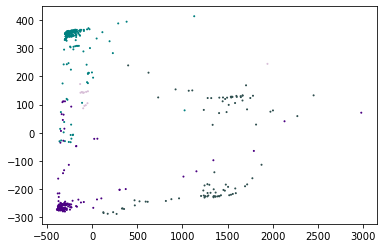

In [81]:


spectral = SpectralClustering(
        n_clusters=4,
        eigen_solver="arpack",
        assign_labels="discretize",
        affinity="precomputed_nearest_neighbors",
)


dbscan = DBSCAN(eps=2, min_samples=int(sum(usegscount)*.1), metric="precomputed")

Z= spectral.fit_predict(X)
Y  = dbscan.fit_predict(X, sample_weight=usegscount)
colors = np.array(["#4B0082","#008080","#2F4F4F","#D8BFD8","#8B4513","#808080","#FF6347","#F0F8FF","#D3D3D3","#4169E1","#DA70D6","#FFFFFF","#DB7093","#87CEEB","#F8F8FF","#FFB6C1","#FAEBD7","#9ACD32","#A9A9A9","red"])

plt.scatter(s1, s2, s=1, color=colors[Z])

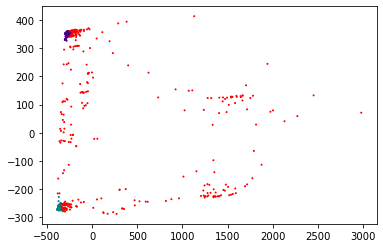

In [82]:
plt.scatter(s1, s2, s=1, color=colors[Y])

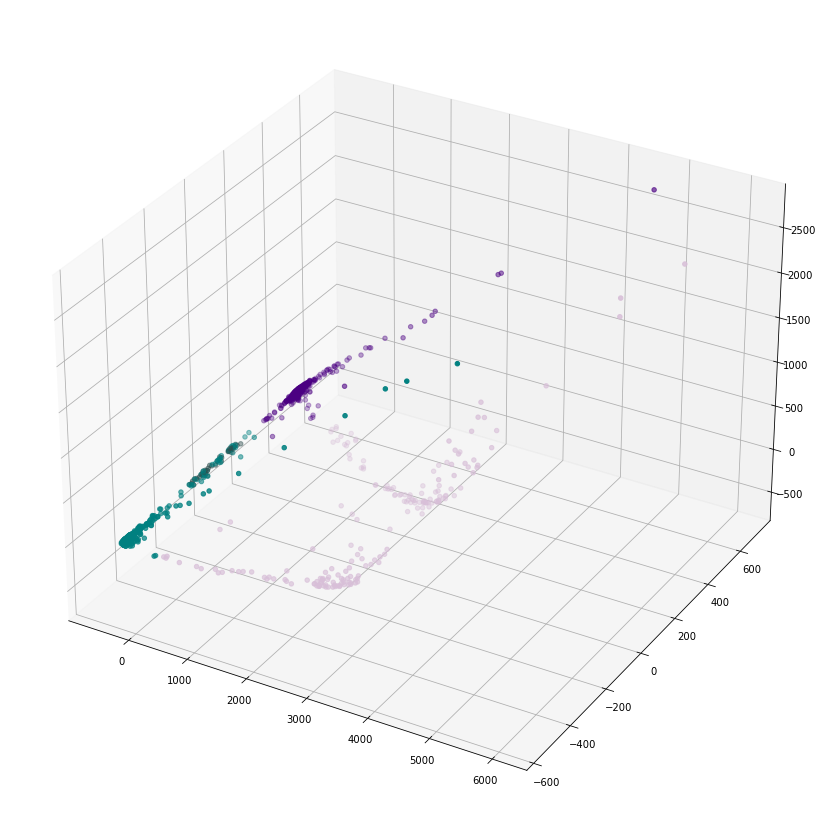

In [52]:
fig = plt.figure(figsize = (20, 15))
ax = plt.axes(projection ="3d")
ax.scatter3D(s1, s2, s3, color=colors[Z])

Counter({0: 1798})

In [ ]:
final_seqs